In [1]:
import numpy as np
import pandas as pd
import sqlite3
import math
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/xipengdu/anaconda3/envs/PIC16B-24W/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in the data from the database
conn = sqlite3.connect('data/tables_v2.db')
# show database content
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('df_2023_h1_feature',), ('df_2023_h1_full',), ('df_2023_h1_target',)]


In [3]:
df_2023_h1= pd.read_sql_query("SELECT * from df_2023_h1_full", conn)
conn.close()

In [4]:
df_2023_h1

,[EXPIRE_UNIX],[QUOTE_DATE],[EXPIRE_DATE],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],...,[P_DELTA],[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK],Adj Close
0,0.0,2023-05-26 00:00:00,2023-06-01 00:00:00,0.398131,0.996074,1.00000,0.000000,0.000000,0.773089,0.030900,...,0.99295,0.022251,0.008555,0.806394,0.999305,0.398016,0.000000,0.000209,0.000208,417.090668
1,0.0,2023-05-19 00:00:00,2023-06-01 00:00:00,0.429907,0.962454,0.93071,0.134073,0.009664,0.299637,0.060702,...,0.98145,0.059162,0.027545,0.822201,0.997674,0.215490,0.000888,0.000454,0.000450,417.090668
2,0.0,2023-05-23 00:00:00,2023-06-01 00:00:00,0.405607,0.851043,0.96456,0.077427,0.004808,0.276146,0.043192,...,0.98968,0.030628,0.013434,0.844129,0.998821,0.286507,0.000000,0.000244,0.000242,417.090668
3,0.0,2023-05-31 00:00:00,2023-06-01 00:00:00,0.517757,0.942822,0.01620,0.277256,0.001097,0.884935,0.000438,...,0.00000,0.000262,0.000000,1.000000,1.000000,0.000150,0.013772,0.031577,0.032030,417.090668
4,0.0,2023-05-22 00:00:00,2023-06-01 00:00:00,0.480374,0.966626,0.85283,0.541133,0.014860,0.184894,0.046564,...,0.85853,0.495812,0.118723,0.315724,0.986642,0.145524,0.095957,0.003001,0.002975,417.090668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,1.0,2023-03-21 00:00:00,2023-12-29 00:00:00,0.579439,0.476319,0.20468,0.153999,0.089912,0.849538,0.273499,...,0.04262,0.242147,0.176923,0.985857,0.792505,0.135903,0.000000,0.210572,0.215323,475.309998
238,1.0,2023-01-19 00:00:00,2023-12-29 00:00:00,0.411215,0.226503,0.67584,0.114147,0.119814,0.707121,0.924686,...,0.67245,0.117539,0.988534,0.804552,0.129268,0.203660,0.000000,0.068353,0.073642,475.309998
239,1.0,2023-02-07 00:00:00,2023-12-29 00:00:00,0.426168,0.879509,0.73463,0.099345,0.111786,0.715901,1.000000,...,0.74933,0.100785,0.908639,0.804790,0.291826,0.195399,0.000000,0.048046,0.050086,475.309998
240,1.0,2023-01-05 00:00:00,2023-12-29 00:00:00,0.398131,0.000000,0.66578,0.108170,0.121014,0.699857,0.911964,...,0.65909,0.109686,1.000000,0.792073,0.072707,0.221789,0.000000,0.076762,0.088170,475.309998


In [8]:
df_2023_h1= df_2023_h1.drop(['[QUOTE_DATE]', '[EXPIRE_UNIX]'], axis=1)
df_2023_h1['item'] = 'SPY'
df_2023_h1.shape

(242, 23)

In [48]:
test_dates = 3
train = df_2023_h1[: 242 - (test_dates * 11)]
test = df_2023_h1[- (test_dates * 11) :]

In [14]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column = 'item',
    timestamp_column="[EXPIRE_DATE]"
)
train_data.head()

[STRIKE]  [UNDERLYING_LAST]  [C_DELTA]  [C_GAMMA]  \
item_id timestamp                                                       
SPY     2023-06-01  0.398131           0.996074    1.00000   0.000000   
        2023-06-01  0.429907           0.962454    0.93071   0.134073   
        2023-06-01  0.405607           0.851043    0.96456   0.077427   
        2023-06-01  0.517757           0.942822    0.01620   0.277256   
        2023-06-01  0.480374           0.966626    0.85283   0.541133   

                    [C_VEGA]  [C_THETA]   [C_RHO]    [C_IV]  [C_VOLUME]  \
item_id timestamp                                                         
SPY     2023-06-01  0.000000   0.773089  0.030900  0.000110         0.0   
        2023-06-01  0.009664   0.299637  0.060702  0.181157         0.0   
        2023-06-01  0.004808   0.276146  0.043192  0.221098         0.0   
        2023-06-01  0.001097   0.884935  0.000438  0.077502         1.0   
        2023-06-01  0.014860   0.184894  0.046564  0.088429         0.0   

                     [C_BID]  ...  [P_DELTA]  [P_GAMMA]  [P_VEGA]  [P_THETA]  \
item_id timestamp             ...                                              
SPY     2023-06-01  0.216103  ...    0.99295   0.022251  0.008555   0.806394   
        2023-06-01  0.150028  ...    0.98145   0.059162  0.027545   0.822201   
        2023-06-01  0.179777  ...    0.98968   0.030628  0.013434   0.844129   
        2023-06-01  0.000076  ...    0.00000   0.000262  0.000000   1.000000   
        2023-06-01  0.049896  ...    0.85853   0.495812  0.118723   0.315724   

                     [P_RHO]    [P_IV]  [P_VOLUME]   [P_BID]   [P_ASK]  \
item_id timestamp                                                        
SPY     2023-06-01  0.999305  0.398016    0.000000  0.000209  0.000208   
        2023-06-01  0.997674  0.215490    0.000888  0.000454  0.000450   
        2023-06-01  0.998821  0.286507    0.000000  0.000244  0.000242   
        2023-06-01  1.000000  0.000150    0.013772  0.031577  0.032030   
        2023-06-01  0.986642  0.145524    0.095957  0.003001  0.002975   

                     Adj Close  
item_id timestamp               
SPY     2023-06-01  417.090668  
        2023-06-01  417.090668  
        2023-06-01  417.090668  
        2023-06-01  417.090668  
        2023-06-01  417.090668  

[5 rows x 21 columns]

In [12]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column = 'item',
    timestamp_column="[EXPIRE_DATE]"
)
test_data.head()

[STRIKE]  [UNDERLYING_LAST]  [C_DELTA]  [C_GAMMA]  \
item_id timestamp                                                       
SPY     2023-11-17  0.542056           0.942822    0.36824   0.250498   
        2023-11-17  0.485981           0.942822    0.61664   0.194990   
        2023-11-17  0.504673           0.942822    0.54586   0.221178   
        2023-11-17  0.467290           0.942822    0.67601   0.170225   
        2023-11-17  0.551402           0.942822    0.31986   0.248221   

                    [C_VEGA]  [C_THETA]   [C_RHO]  [C_IV]  [C_VOLUME]  \
item_id timestamp                                                       
SPY     2023-11-17  0.096509   0.736174  0.310718     0.0         0.0   
        2023-11-17  0.096996   0.646486  0.494539     0.0         0.0   
        2023-11-17  0.100936   0.662989  0.445719     0.0         0.0   
        2023-11-17  0.090988   0.641015  0.532016     0.0         0.0   
        2023-11-17  0.091639   0.763159  0.271326     0.0         0.0   

                     [C_BID]  ...  [P_DELTA]  [P_GAMMA]  [P_VEGA]  [P_THETA]  \
item_id timestamp             ...                                              
SPY     2023-11-17  0.038405  ...    0.31207   0.303403  0.704679   0.851735   
        2023-11-17  0.102060  ...    0.62069   0.204188  0.791353   0.734490   
        2023-11-17  0.075902  ...    0.53806   0.239529  0.820888   0.760994   
        2023-11-17  0.130335  ...    0.68752   0.173037  0.739121   0.725814   
        2023-11-17  0.030278  ...    0.25144   0.307853  0.622816   0.879071   

                     [P_RHO]    [P_IV]  [P_VOLUME]   [P_BID]   [P_ASK]  \
item_id timestamp                                                        
SPY     2023-11-17  0.364314  0.123224    0.000000  0.086741  0.097440   
        2023-11-17  0.466383  0.158079    0.000000  0.049442  0.049291   
        2023-11-17  0.396690  0.145392    0.000000  0.053873  0.065756   
        2023-11-17  0.540503  0.170121    0.009329  0.040789  0.040643   
        2023-11-17  0.404754  0.121263    0.000000  0.098709  0.109512   

                     Adj Close  
item_id timestamp               
SPY     2023-11-17  448.969696  
        2023-11-17  448.969696  
        2023-11-17  448.969696  
        2023-11-17  448.969696  
        2023-11-17  448.969696  

[5 rows x 21 columns]

In [32]:
predictor = TimeSeriesPredictor(
    prediction_length=20,
    path = 'ag_ts_1', 
    target="Adj Close",
    freq="D",
    eval_metric="MSE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'ag_ts_1'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.11.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Wed Dec 20 21:33:31 PST 2023; root:xnu-10002.81.5~7/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       1.36 GB / 8.00 GB (17.0%)
Disk Space Avail:   203.24 GB / 460.43 GB (44.1%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'D',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 20,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'Adj Close',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to freq

In [16]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-48.516394,1.294754,0.162153,7
1,SeasonalNaive,-48.674610,0.715771,0.004430,2
2,Naive,-48.674610,1.257648,0.003697,1
3,ETS,-48.674610,7.271072,0.002884,3
4,DirectTabular,-64.110513,0.037106,2.878776,6
5,RecursiveTabular,-65.736808,0.395240,1.179867,5
6,Theta,-68.995063,7.437099,0.003161,4


In [68]:
for timestamp in test_data[test_data.item == ['SPY']]:
    print(timestamp)

AttributeError: 'TimeSeriesDataFrame' object has no attribute 'item'

In [33]:
predictions = predictor.predict(test_data)

data with frequency 'None' has been resampled to frequency 'D'.


data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [51]:
test

,[EXPIRE_DATE],[STRIKE],[UNDERLYING_LAST],[C_DELTA],[C_GAMMA],[C_VEGA],[C_THETA],[C_RHO],[C_IV],[C_VOLUME],...,[P_GAMMA],[P_VEGA],[P_THETA],[P_RHO],[P_IV],[P_VOLUME],[P_BID],[P_ASK],Adj Close,item
209,2023-11-17 00:00:00,0.542056,0.942822,0.36824,0.250498,0.096509,0.736174,0.310718,0.000000,0.000000,...,0.303403,0.704679,0.851735,0.364314,0.123224,0.000000,0.086741,0.097440,448.969696,SPY
210,2023-11-17 00:00:00,0.485981,0.942822,0.61664,0.194990,0.096996,0.646486,0.494539,0.000000,0.000000,...,0.204188,0.791353,0.734490,0.466383,0.158079,0.000000,0.049442,0.049291,448.969696,SPY
211,2023-11-17 00:00:00,0.504673,0.942822,0.54586,0.221178,0.100936,0.662989,0.445719,0.000000,0.000000,...,0.239529,0.820888,0.760994,0.396690,0.145392,0.000000,0.053873,0.065756,448.969696,SPY
212,2023-11-17 00:00:00,0.467290,0.942822,0.67601,0.170225,0.090988,0.641015,0.532016,0.000000,0.000000,...,0.173037,0.739121,0.725814,0.540503,0.170121,0.009329,0.040789,0.040643,448.969696,SPY
213,2023-11-17 00:00:00,0.551402,0.942822,0.31986,0.248221,0.091639,0.763159,0.271326,0.000000,0.000000,...,0.307853,0.622816,0.879071,0.404754,0.121263,0.000000,0.098709,0.109512,448.969696,SPY
214,2023-11-17 00:00:00,0.532710,0.942822,0.41652,0.247652,0.099735,0.714154,0.348804,0.000000,0.001797,...,0.288220,0.767824,0.824281,0.342517,0.129153,0.000000,0.077216,0.087790,448.969696,SPY
215,2023-11-17 00:00:00,0.495327,0.942822,0.58231,0.207515,0.099274,0.654163,0.471854,0.000000,0.001797,...,0.219634,0.810653,0.748752,0.430057,0.152804,0.068858,0.054571,0.054306,448.969696,SPY
216,2023-11-17 00:00:00,0.514019,0.942822,0.50417,0.242812,0.101746,0.688227,0.417172,0.000000,0.014376,...,0.255759,0.820188,0.780010,0.366609,0.139658,0.000000,0.060502,0.072363,448.969696,SPY
217,2023-11-17 00:00:00,0.523364,0.942822,0.46263,0.240535,0.101418,0.692134,0.384339,0.000000,0.136568,...,0.272775,0.804448,0.799025,0.347435,0.134127,0.000000,0.068144,0.079696,448.969696,SPY
218,2023-11-17 00:00:00,0.476636,0.942822,0.64734,0.181896,0.094166,0.642808,0.514543,0.000000,0.000000,...,0.188743,0.767581,0.731875,0.503654,0.164122,0.000000,0.044906,0.044690,448.969696,SPY


In [50]:
predictions

mean         0.1         0.2         0.3  \
item_id timestamp                                                    
SPY     2023-12-30  473.711997  468.706268  470.424632  471.663693   
        2023-12-31  473.711997  466.632828  469.062961  470.815258   
        2024-01-01  472.503470  463.833296  466.809589  468.955705   
        2024-01-02  472.503470  462.492015  465.928742  468.406864   
        2024-01-03  472.503470  461.310323  465.152701  467.923325   
        2024-01-04  472.503470  460.241992  464.451106  467.486173   
        2024-01-05  472.506327  459.262420  463.808782  467.087029   
        2024-01-06  472.506327  458.347994  463.208260  466.712854   
        2024-01-07  472.506327  457.489147  462.644238  466.361420   
        2024-01-08  472.503470  456.673970  462.107912  466.026167   
        2024-01-09  472.503470  455.901350  461.600517  465.710018   
        2024-01-10  472.503470  455.163122  461.115707  465.407940   
        2024-01-11  472.569659  454.521253  460.716900  465.184398   
        2024-01-12  472.572520  453.842802  460.272329  464.908471   
        2024-01-13  472.933654  453.546555  460.201748  465.000611   
        2024-01-14  472.933654  452.910745  459.784198  464.740442   
        2024-01-15  472.930796  452.291652  459.376646  464.485425   
        2024-01-16  472.930796  451.693292  458.983691  464.240581   
        2024-01-17  472.930796  451.111335  458.601508  464.002449   
        2024-01-18  472.930796  450.544501  458.229256  463.770505   
        2024-01-19  472.933654  449.994529  457.869060  463.547151   
        2024-01-20  472.933654  449.454712  457.514550  463.326261   
        2024-01-21  472.933654  448.927029  457.168010  463.110338   
        2024-01-22  472.930796  448.407839  456.826066  462.896200   
        2024-01-23  472.930796  447.902158  456.493975  462.689280   
        2024-01-24  472.930796  447.406493  456.168462  462.486458   
        2024-01-25  472.930796  446.920272  455.849151  462.287500   
        2024-01-26  472.933654  446.445834  455.538559  462.095053   
        2024-01-27  472.933654  445.976987  455.230657  461.903205   
        2024-01-28  472.933654  445.516156  454.928020  461.714636   
        2024-01-29  472.930796  445.060084  454.627527  461.526326   
        2024-01-30  472.930796  444.614124  454.334656  461.343843   
        2024-01-31  472.930796  444.175080  454.046327  461.164190   
        2024-02-01  472.503470  443.315314  453.335009  460.559913   
        2024-02-02  472.506327  442.892047  453.058022  460.388405   
        2024-02-03  472.506327  442.471965  452.782145  460.216511   
        2024-02-04  472.506327  442.057678  452.510075  460.046988   
        2024-02-05  472.503470  441.646094  452.238797  459.876882   
        2024-02-06  472.503470  441.242712  451.973888  459.711822   
        2024-02-07  472.503470  440.844470  451.712355  459.548864   
        2024-02-08  472.503470  440.451175  451.454070  459.387931   
        2024-02-09  472.506327  440.065508  451.201776  459.231808   
        2024-02-10  472.506327  439.681579  450.949642  459.074708   
        2024-02-11  472.572520  439.368280  450.766613  458.985614   
        2024-02-12  472.569659  438.990219  450.517352  458.829225   
        2024-02-13  472.930796  438.980300  450.634807  459.038528   
        2024-02-14  472.930796  438.613257  450.393763  458.888337   
        2024-02-15  472.930796  438.250098  450.155269  458.739735   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
SPY     2023-12-30  472.722425  473.711996  474.701567  475.760299   
        2023-12-31  472.312531  473.711996  475.111461  476.608734   
        2024-01-01  470.789483  472.503470  474.217458  476.051235   
        2024-01-02  470.524328  472.503470  474.482613  476.600077   
        2024-01-03  470.290722  472.503470  474.716219  477.083615   
        2024-01-04  470.079526  472

In [35]:
item_id = 'SPY'
y_past = train_data.loc[item_id]["Adj Close"]
y_pred = predictions.loc[item_id]['mean']
y_test = test_data.loc[item_id]["Adj Close"][-20:]

In [83]:
import yfinance as yf
target = pd.DataFrame(yf.download(['SPY'], start="2023-12-30", end="2024-02-15")['Adj Close'])

[*********************100%%**********************]  1 of 1 completed


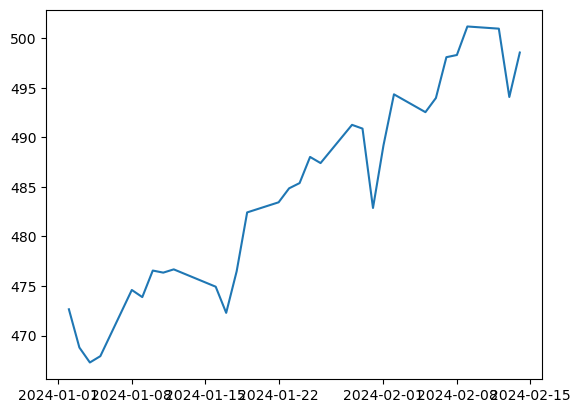

In [84]:
plt.plot(target)

In [23]:
from sklearn import metrics
print(metrics.r2_score(y_true=y_test, y_pred=y_pred))
print(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [33, 48]

In [ ]:
r2_list = []
mse_list = []
X_list = []
for i in range(10):
    X_test = ds.iloc[10000 + i * 10000:11000 + i * 10000]
    y_test = target.iloc[10000 + i * 10000:11000 + i * 10000]
    y_pred = predictor.predict(X_test)
    X_list.append(10000 + i * 10000)
    r2_list.append(metrics.r2_score(y_true=y_test, y_pred=y_pred))
    mse_list.append(metrics.mean_squared_error(y_true=y_test, y_pred=y_pred))

Text(0.5, 1.0, 'R2 Score for Autogluon Model')

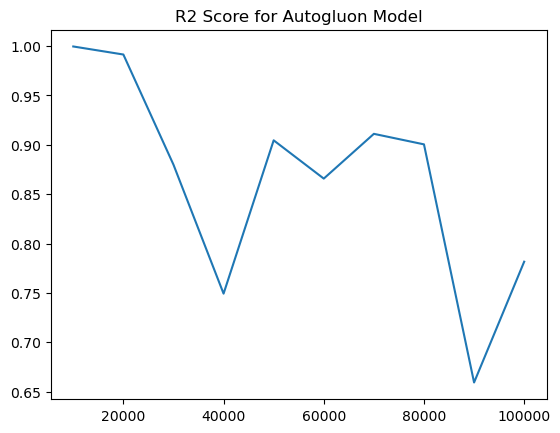

In [ ]:
plt.plot(X_list, r2_list)
plt.title('R2 Score for Autogluon Model')

Text(0.5, 1.0, 'MSE Loss for Autogluon Model')

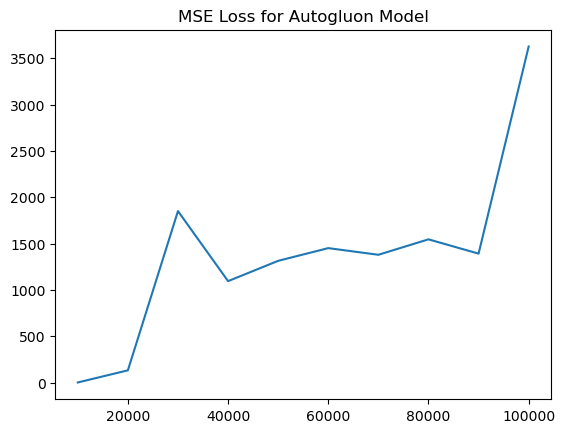

In [ ]:
plt.plot(X_list, mse_list)
plt.title('MSE Loss for Autogluon Model')